In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy 
from scipy.stats import spearmanr, pearsonr, mannwhitneyu
from sklearn.preprocessing import OneHotEncoder

In [3]:
users_ = pd.read_csv('users-details-2023.csv')

In [4]:
df_anime = pd.read_csv('anime-dataset-2023.csv')

# Проанализируем датасет с информацией о пользователях сервиса MyAnimeList

In [129]:
users = users_.copy()

In [ ]:
#удалим мусорные записи - содержат Nan в нескольких столбцах
users = users.drop([7532, 74352, 120266, 147943, 196115, 196899, 233070, 470599], axis=0)

#приведем к формату времени даты дни рождений и присоединения к платформе
users['Joined'] = pd.to_datetime(users['Joined'])
mask = ~users['Birthday'].isna()
users.loc[mask, 'Birthday'] = pd.to_datetime(users.loc[mask, "Birthday"].str.slice(0, 10), format="%Y-%m-%d", errors="coerce")

#(2023-2004) * 365 = 6935 - максимальное количество дней, прошедшее с момента образования платформы до даты сбора данных
#Удалим строки, в которых количество дней просмотра больше 7000
mask3 = (users['Days Watched'] < 7000.0)
users = users[mask3]

#почистим Nan в столбцах
users = users[~users['Birthday'].isna()]
users = users[~users['Location'].isna()]
users = users[~users['Joined'].isna()]
users = users[~users['Gender'].isna()]

#Заменим возраст объектов, возраст которых был больше 100 на наиболее частотный '1990-01-01', для пользователей, чьей датой рождения была выставлена дата позже 2012-05-06 (самая поздняя дата присоединения к сервису), выставим дату рождения 2012-05-06 
mask1 = (users['Birthday'] < datetime.strptime('1923-01-01', "%Y-%m-%d"))
mask2 = (users['Birthday'] > datetime.strptime('2012-05-06', "%Y-%m-%d"))
users.loc[mask1, 'Birthday'] = datetime.strptime('1990-01-01', "%Y-%m-%d")
users.loc[mask2, 'Birthday'] = datetime.strptime('2012-05-06', "%Y-%m-%d")

#Удалим дублирующиеся строчки
users = users.drop_duplicates()

In [13]:
users['Location']

0                        California
5                    Bergen, Norway
11                      Calgary, AB
16                    Paris, France
23                   London,England
                    ...            
731265                     mansoura
731266              Palm Desert, CA
731269             Toronto, Ontario
731270               Moscow, Russia
731280    Newport Coast, California
Name: Location, Length: 115448, dtype: object

Колонку Location нужно парсить, тк там нет единого формата описания локации, плюс на данном сайте большая часть пользователей скорее всего не ставила свое истинное местоположение, поэтому скорее всего каких-то статистических зависимостей нет и пока что я ее использовать не буду

#### Посмотрим распределения 
'Gender', 'Birthday', 'Joined',
       'Days Watched', 'Mean Score', 'Watching', 'Completed', 'On Hold',
       'Dropped', 'Plan to Watch', 'Total Entries', 'Rewatched',
       'Episodes Watched'

### Построим barplot для 'Gender'
Гистограммы для 'Birthday', 'Joined' и 'Mean Score'
Возьмем логарифм для 'Days Watched', 'Watching', 'Completed', 'On Hold',
       'Dropped', 'Plan to Watch', 'Total Entries', 'Rewatched',
       'Episodes Watched' и гистограммы


<Axes: xlabel='Gender', ylabel='Count'>

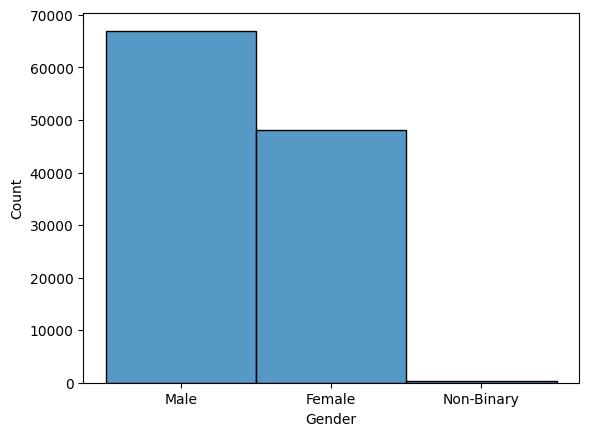

In [18]:
sns.histplot(data=users, x = 'Gender')

Среди пользователей платформы преобладают мужчины

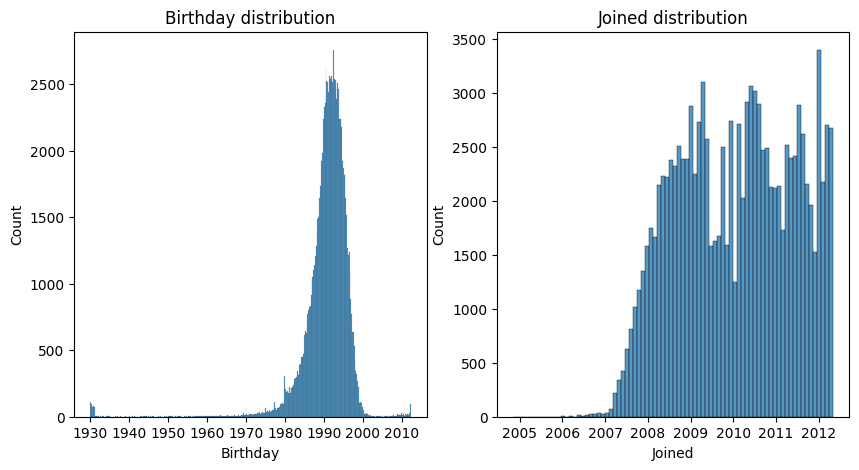

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(10, 5))

columns = ['Birthday', 'Joined']
for i in range(2):
    sns.histplot(data=users, ax = ax[i], x = columns[i]).set_title(f'{columns[i]} distribution')


Возраст пользователей платформы распределен нормально с одной модой.
Время присоединения пользователей к платформе распределено равномерно c 2007 по 2012 год

<Axes: xlabel='Mean Score', ylabel='Count'>

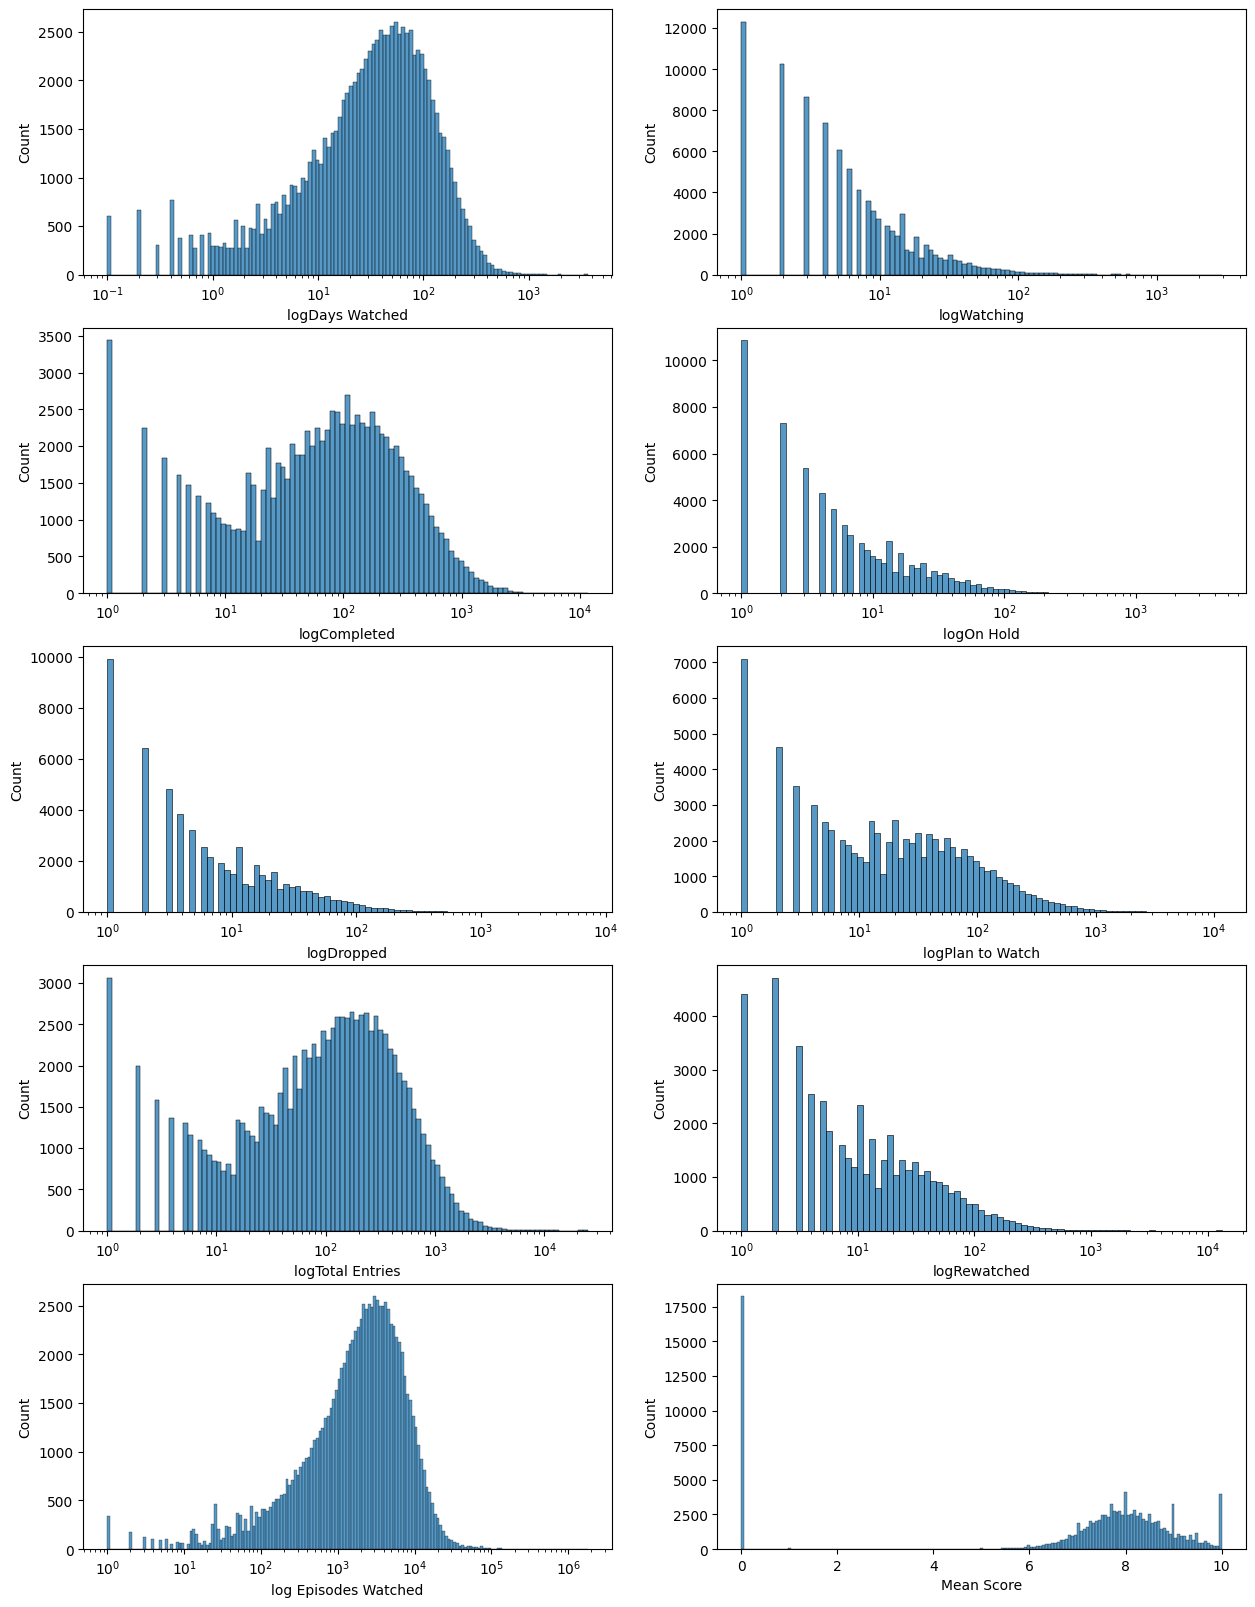

In [131]:
fig, ax = plt.subplots(nrows=5, ncols = 2, figsize=(15, 20))

columns = ['Days Watched', 'Watching', 'Completed', 'On Hold',
       'Dropped', 'Plan to Watch', 'Total Entries', 'Rewatched',
       'Episodes Watched']

for i in range(4):
    for j in range(2):
        sns.histplot(data=users, ax = ax[i][j], x=columns[2*i + j], log_scale=True).set_xlabel(f'log{columns[2*i + j]}')

sns.histplot(data=users, x='Episodes Watched', ax=ax[4][0], log_scale = True).set_xlabel(f'log Episodes Watched')
sns.histplot(data=users, x='Mean Score', ax=ax[4][1])

По распределениям видно, что есть аномально активные пользователи по добавлению аниме в списки и по количеству просмотренных серий аниме, проверим сколько пользователей проявляет подобную активность, большую 97,5 персентиля по каждому из признаков:

In [52]:
watching_percentile = np.percentile(users['Watching'], q=97.5)
completed_percentile = np.percentile(users['Completed'], q=97.5)
hold_percentile = np.percentile(users['On Hold'], q=97.5)
dropped_percentile = np.percentile(users['Dropped'], q=97.5)
plans_percentile = np.percentile(users['Plan to Watch'], q=97.5)
episodes_percentile = np.percentile(users['Episodes Watched'], q=97.5)
print(f'watching {watching_percentile}\ncompleted {completed_percentile}\non-hold {hold_percentile}\ndropped {dropped_percentile}\nplan to watch {plans_percentile}\nepisodes {episodes_percentile}')

watching 55.0
completed 807.0
on-hold 51.0
dropped 70.0
plan to watch 275.0
episodes 15242.299999999988


In [53]:
anomal_watching_users_id = users.loc[users['Watching'] > 55, 'Mal ID']
anomal_completed_users_id = users.loc[users['Completed'] > 807, 'Mal ID']
anomal_hold_users_id = users.loc[users['On Hold'] > 51, 'Mal ID']
anomal_dropped_users_id = users.loc[users['Dropped'] > 70, 'Mal ID']
anomal_plan_users_id = users.loc[users['Plan to Watch'] > 275, 'Mal ID']
anomal_episodes_watched = users.loc[users['Episodes Watched'] > 15242.299999999988, 'Mal ID']

In [54]:
inter = pd.merge(anomal_watching_users_id, anomal_completed_users_id, how='inner')
inter = pd.merge(inter, anomal_hold_users_id, how='inner')
inter = pd.merge(inter, anomal_dropped_users_id, how='inner')
inter = pd.merge(inter, anomal_plan_users_id, how='inner')
inter = pd.merge(inter, anomal_episodes_watched, how='inner')
inter

,Mal ID
0,22865
1,27069
2,61028
3,94637
4,100970
5,129090
6,155289
7,164919
8,166325
9,247437


Всего оказалось 17 аномально активных пользователей, которые очень активно добавляют аниме в списки и смотрят много серий аниме

#### Проверим еще сколько среди данных аномально активных пользователей пользователей, которые добавляют аниме активно в каждый из списков, но при этом не смотрят аниме на данной платформе

In [57]:
episodes_percentile = np.percentile(users['Episodes Watched'], q=2.5)
episodes_percentile

np.float64(0.0)

In [58]:
no_episodes_watched = users.loc[users['Episodes Watched']==0, 'Mal ID']
no_episodes = pd.merge(anomal_watching_users_id, anomal_completed_users_id, how='inner')
no_episodes = pd.merge(inter, anomal_hold_users_id, how='inner')
no_episodes = pd.merge(inter, anomal_dropped_users_id, how='inner')
no_episodes = pd.merge(inter, anomal_plan_users_id, how='inner')
no_episodes = pd.merge(inter, no_episodes_watched, how='inner')
no_episodes

,Mal ID


Как оказалось пользователей активно добавляющих аниме в каждый из списков, но при этом совсем несмотрящих аниме на данном сайте, нет. Будем считать данных людей энтузиастами и активными пользователями списков платформы

In [ ]:
mask = users.loc[users['Mal ID'].isin(inter['Mal ID']), :]
enthusiasts = users.loc[~users['Mal ID'].isin(inter['Mal ID']), :]
enthusiasts

Всего энтузиастов оказалось очень мало по сравнению с остальными пользователями платформы, поэтому из-за малого размера выборки проведение статистического теста в данном случае не представляется возможным.

Проверим еще есть ли отличия между мужчинами и женшинами по средним оценкам, которые они ставят аниме:

In [ ]:
men_women = users.loc[users['Gender'] != 'Non-Binary', :]
men_women = men_women.loc[men_women['Mean Score'] > 0, :] #отбросим ноль, потому что ноль в среднем могли поставить только совсем неактивные пользователи, таких пользователей учитывать не будем

<Axes: xlabel='Mean Score', ylabel='Density'>

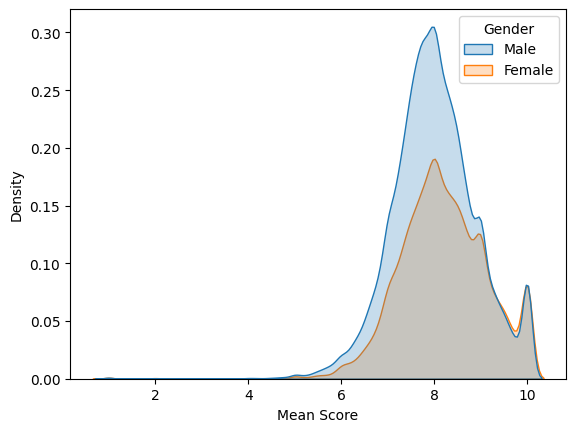

In [ ]:
sns.kdeplot(data=men_women, x = 'Mean Score', hue='Gender', fill=True)

In [797]:
men = men_women.loc[men_women['Gender'] == 'Male', :]
women = men_women.loc[men_women['Gender'] != 'Male', :]

In [799]:
res = mannwhitneyu(men['Mean Score'], women['Mean Score'])
print(f'statistics {res.statistic}\np-value {res.pvalue}')

statistics 989079914.5
p-value 2.593266439696271e-233


In [800]:
women['Mean Score'].describe()

count    39021.000000
mean         8.187091
std          0.955625
min          1.000000
25%          7.580000
50%          8.140000
75%          8.830000
max         10.000000
Name: Mean Score, dtype: float64

In [801]:
men['Mean Score'].describe()

count    57828.000000
mean         7.993728
std          0.909145
min          1.000000
25%          7.440000
50%          7.970000
75%          8.540000
max         10.000000
Name: Mean Score, dtype: float64

In [802]:
8.187091 - 7.993728

0.19336300000000062

Есть статистически значимое свидетельство того, что в среднем средняя оценка оценок, выставленных женщинами аниме, выше, чем таковая для мужчин на 0.19336

# Проанализируем таблицу с информацией по аниме

In [291]:
df_anime.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Type', 'Episodes', 'Aired', 'Premiered', 'Status',
       'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating',
       'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL'],
      dtype='object')

#### Удалим колонки 'Other name', 'Synopsis', 'Image URL', поскольку первая колонка имеет название на японском, для анализа второй придется использовать методы обработки текста, а для третьей вероятно методы обработки изображений 

In [5]:
df_anime = df_anime.drop(['Other name', 'Synopsis', 'Image URL'], axis=1)

In [6]:
anime_ = df_anime.copy()

In [7]:
columns = anime_.columns

for column in columns:
    print(f'{column}: {anime_.loc[(anime_[column] == 'UNKNOWN') | (anime_[column] == 0) | (anime_[column] == 'Unknown'),].shape[0]}')

anime_id: 0
Name: 0
English name: 14577
Score: 9213
Genres: 4929
Type: 74
Episodes: 611
Aired: 0
Premiered: 19399
Status: 0
Producers: 13350
Licensors: 20170
Studios: 10526
Source: 3689
Duration: 663
Rating: 669
Rank: 4612
Popularity: 187
Favorites: 10808
Scored By: 9213
Members: 186


Более 70% данных в колонках Premiered, Licensors занимают 'UNKOWN' и возможности восстановить данные в этих колонках нет, поэтому удалим колонки полностью

In [8]:
anime_ = anime_.drop(['Premiered', 'Licensors'], axis=1)

In [9]:
anime_ = anime_.drop_duplicates() #удалим дубликаты

Дубликатов не обнаружено

In [167]:
anime_['Rating'].unique()

array(['R - 17+ (violence & profanity)', 'PG-13 - Teens 13 or older',
       'PG - Children', 'R+ - Mild Nudity', 'G - All Ages', 'Rx - Hentai',
       'UNKNOWN'], dtype=object)

Всего 6 категорий по возрастному рейтингу плюс одна категория для пользователей с неизвестной возрастной категорией

#### Переведем столбец длительности аниме к единому формату в секундах

In [10]:
import re

time_patterns = [
    (re.compile(r"\d+ hr"), 60 * 60), #pattern, period in secs
    (re.compile(r"\d+ min"), 60),
    (re.compile(r"\d+ sec"), 1),
]

def parse_time(time_str: str):
    total_time = 0

    if "Unknown" in time_str:
        return 0

    for pattern, period_secs in time_patterns: #проходимся по time_patterns и ищем есть ли эти паттерны в нашем времени
        found = pattern.findall(time_str)
        assert len(found) <= 1 #если часов или минут или секунд в данном времени нет, то не будем учитывать  их при расчете суммарного времени
        if found:
            total_time += period_secs * int(found[0].split()[0]) #берем конкретное заданное количество часов/минут/секунд в паттерне и переводим в секунды
    
    return total_time

In [11]:
anime_['Duration'] = anime_['Duration'].apply(parse_time)

#### Распарсим жанры

In [12]:
def genres(genre):
    if genre != 'UNKNOWN': 
        genre = genre.split(', ')
    else:
        genre = []
    return genre

In [13]:
anime_['Genres'] = anime_.loc[:, 'Genres'].apply(genres)

In [14]:
values_ = anime_['Genres'].values
unique_genres = []
for elem in values_:
    for genre in elem:
        unique_genres.append(genre)

unique_genres = list(set(unique_genres))
unique_genres


['Adventure',
 'Comedy',
 'Sports',
 'Slice of Life',
 'Girls Love',
 'Boys Love',
 'Hentai',
 'Avant Garde',
 'Romance',
 'Erotica',
 'Drama',
 'Horror',
 'Suspense',
 'Action',
 'Fantasy',
 'Gourmet',
 'Mystery',
 'Ecchi',
 'Sci-Fi',
 'Supernatural',
 'Award Winning']

In [15]:
def encode_categories(categories: pd.Series, unique_categories: list[str]) -> pd.DataFrame:
    return pd.DataFrame({f'is_{categ}': categories.apply(lambda x: categ in x) for categ in unique_categories})

In [16]:
new_genres = encode_categories(anime_['Genres'], unique_genres)

In [17]:
anime_ = anime_.drop(['Genres'], axis=1)

In [18]:
anime_ = pd.concat([anime_, new_genres], axis=1)

In [379]:
anime_[['anime_id', 'Name', 'English name', 'Score', 'Type', 'Episodes',
       'Aired', 'Status', 'Producers', 'Studios', 'Source', 'Duration',
       'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members']]

,anime_id,Name,English name,Score,Type,Episodes,Aired,Status,Producers,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members
0,1,Cowboy Bebop,Cowboy Bebop,8.75,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Finished Airing,Bandai Visual,Sunrise,Original,1440,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,8.38,Movie,1.0,"Sep 1, 2001",Finished Airing,"Sunrise, Bandai Visual",Bones,Original,6900,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978
2,6,Trigun,Trigun,8.22,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Finished Airing,Victor Entertainment,Madhouse,Manga,1440,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252
3,7,Witch Hunter Robin,Witch Hunter Robin,7.25,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",Finished Airing,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Original,1500,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931
4,8,Bouken Ou Beet,Beet the Vandel Buster,6.94,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Finished Airing,"TV Tokyo, Dentsu",Toei Animation,Manga,1380,PG - Children,4240.0,5126,14,6413.0,15001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,Wu Nao Monu,UNKNOWN,UNKNOWN,ONA,15.0,"Jul 4, 2023 to ?",Not yet aired,UNKNOWN,UNKNOWN,Web manga,0,PG-13 - Teens 13 or older,UNKNOWN,24723,0,UNKNOWN,0
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,UNKNOWN,ONA,18.0,"Jul 27, 2023 to ?",Not yet aired,UNKNOWN,UNKNOWN,Web novel,0,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0
24902,55733,Di Yi Xulie,The First Order,UNKNOWN,ONA,16.0,"Jul 19, 2023 to ?",Finished Airing,UNKNOWN,UNKNOWN,Web novel,0,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0
24903,55734,Bokura no Saishuu Sensou,UNKNOWN,UNKNOWN,Music,1.0,"Apr 23, 2022",Finished Airing,UNKNOWN,UNKNOWN,Original,180,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0


In [19]:
anime_['Type'].unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'UNKNOWN'],
      dtype=object)

In [20]:
anime_ = anime_.rename(columns={'Duration': 'Duration per episode'})

#### Построим функции плотности всех вещественных фичей

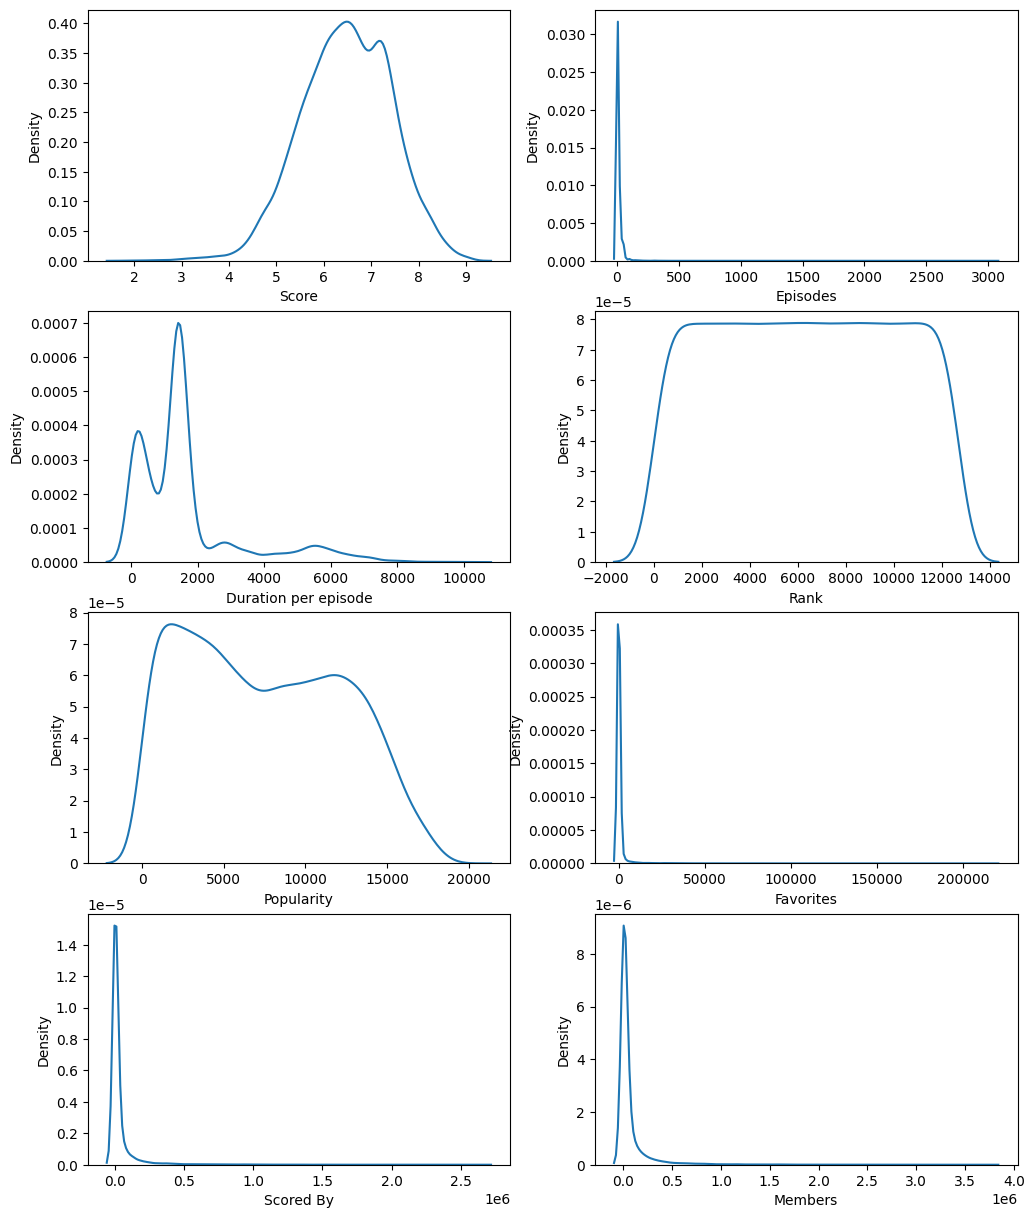

In [ ]:
columns = ['Score', 'Episodes', 'Duration per episode', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members']
mask = ((anime_['Score'] != 'UNKNOWN') & (anime_['Episodes'] != 'UNKNOWN') & (anime_['Duration per episode'] != 'UNKNOWN') & (anime_['Rank'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN') & (anime_['Favorites'] != 'UNKNOWN') & (anime_['Scored By'] != 'UNKNOWN') & (anime_['Members'] != 'UNKNOWN'))
temp = anime_.loc[mask, columns].astype(float)

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize=(12, 15))
for i in range(4):
    for j in range(2):
        sns.kdeplot(data=temp, x = columns[2*i + j], ax=ax[i][j])

#### Видимо, есть две категории аниме по времени (возможно это сериалы и фильмы), рассмотрим аниме каких возрастных категорий в них распространены и к какому типу они относятся

In [649]:
temp = anime_.loc[(anime_['Score'] != 'UNKNOWN'), :].copy()
temp['Score'] = temp['Score'].astype(float)
print(temp['Score'].describe())

count    15692.000000
mean         6.380890
std          0.928696
min          1.850000
25%          5.730000
50%          6.390000
75%          7.060000
max          9.100000
Name: Score, dtype: float64


Распределение оценок аниме является нормальным с двумя модами и средним 6.38

[None, None, None, None, None, None]

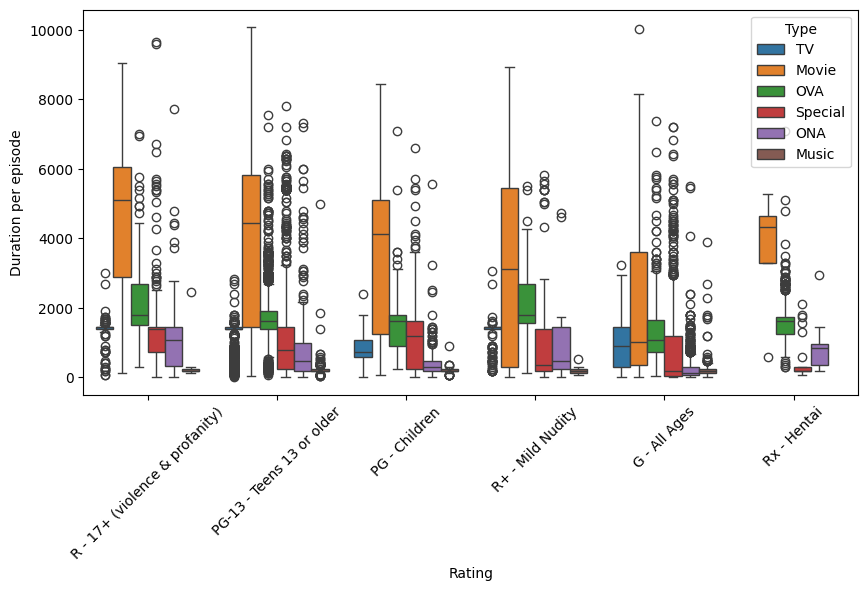

In [602]:
#отбросим все аниме с длительностью равной 0 секунд и отбросим аниме с длительностью более 60000 секунд = 16,67 часов
mask = (anime_['Duration per episode'] != 0) & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN') &(anime_['Duration per episode'] <= 16000)
temp = anime_.loc[mask, ['Duration per episode', 'Rating', 'Type']]

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=temp, x='Rating', y='Duration per episode', hue='Type')
plt.setp(ax.get_xticklabels(), rotation=45)

Двумя категориями по длительности действительно являются фильмы и группа ТВ сериалов, OVA, ONA, special и музыкальных аниме
Самыми длинными аниме по длительности действительно являются фильмы.
Среди Hentai нет сериалов и жанра music, ну оно и ожидаемо...

[None, None, None, None, None, None]

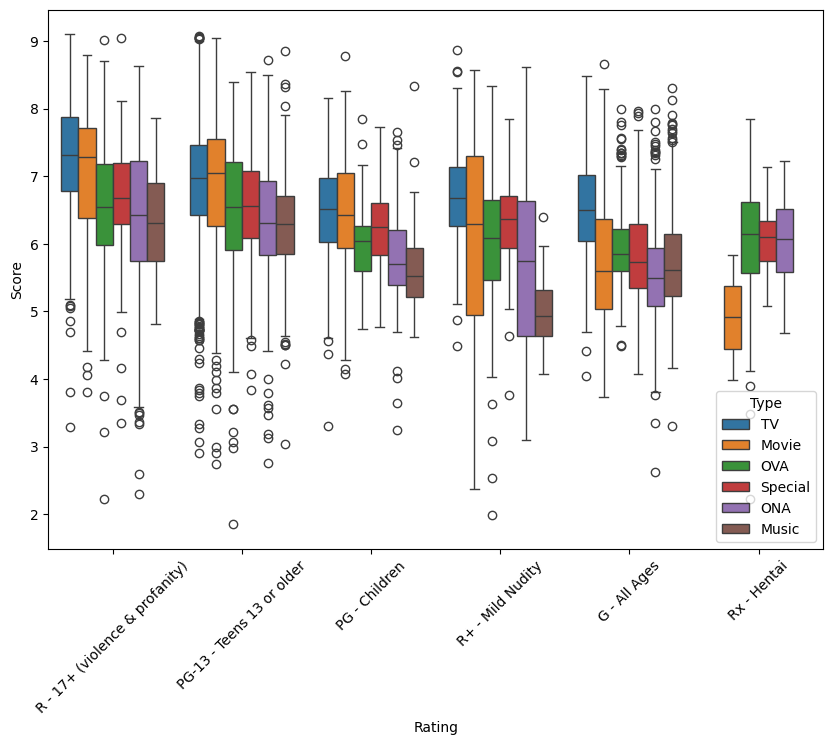

In [681]:
mask = (anime_['Score'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN') #&(anime_['Score'] <= 16000)
temp = anime_.loc[mask, ['Score', 'Rating', 'Type']]
temp['Score'] = temp['Score'].astype(float)
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=temp, x='Rating', y='Score', hue='Type')
plt.setp(ax.get_xticklabels(), rotation=45)

Среди категорий R-17+, PG-13, PG-Children в среднем ТВ сериалы и фильмы обладают более высокой оценкой, чем 4 оставшихся типа.
Среди категории mild nudity в среднем более высокой оценкой обладабт ТВ сериалы по сравнению с другими категориями.
Среди категории All  Ages в среднем более высокую оценку ставят ТВ сериалам.
Среди категории Hentai OVA, Special, ONA получают более высокую оценку, чем фильмы

#### Рассмотрим как связаны популярность и тип аниме

<Axes: xlabel='Type', ylabel='Popularity'>

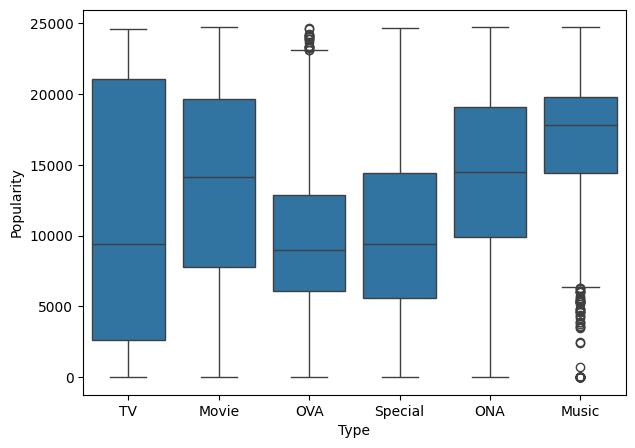

In [ ]:
mask = (anime_['Popularity'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN') #&(anime_['Score'] <= 16000)
temp = anime_.loc[mask, ['Popularity', 'Rating', 'Type']]
temp['Popularity'] = temp['Popularity'].astype(float)
plt.figure(figsize=(7, 5))
sns.boxplot(data=temp, x='Type', y='Popularity')

В среднем как будто наиболее популярными являются Фильмы, ONA и music

#### Рассмотрим как изменяется популярность аниме разных возрастных категорий по типу аниме

[None, None, None, None, None, None]

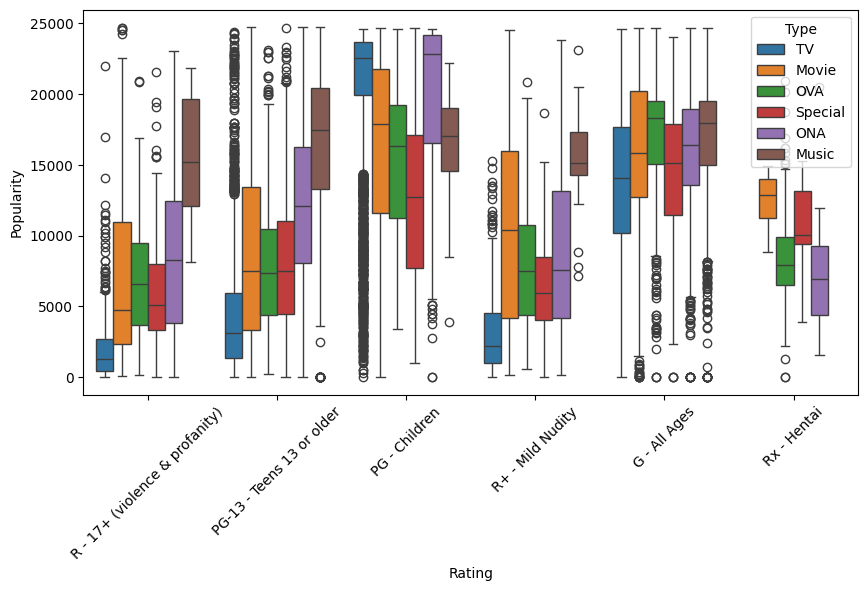

In [606]:
# plt.figure(figsize=(18, 10))
# sns.boxplot(data=anime_, x='Rating', y='Popularity')

mask = (anime_['Popularity'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN') #&(anime_['Score'] <= 16000)
temp = anime_.loc[mask, ['Popularity', 'Rating', 'Type']]
temp['Popularity'] = temp['Popularity'].astype(float)
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=temp, x='Rating', y='Popularity', hue='Type')
plt.setp(ax.get_xticklabels(), rotation=45)

Среди категорий R-17+, PG-13, Mild Nudity, All ages ТВ сериалы обладают в среднем наименьшей популярностью и при этом обладают в среднем более высокой оценкой. Среди этих же категорий в среднем наибольшей популярностью пользуются аниме ONA и Music.
В то же время в категории Children ТВ сериалы в среднем обладают и более высокой оценкой, и более высокой популярностью.
В категории Hentai наибольшей популярностью в среднем пользуются фильмы, но пользователи в среднем ставят им более низкие оценки, относительно аниме других типов.


Разумнее было бы смотреть на favorites, members, но за данными фичами скорее всего будет сложнее отследить, потому что пользователи часто не помечают аниме/не добавляют аниме в список (в особенности те, кто смотрит mild nudity, hentai)
Посмотрим как много пользователей среди каждой возрастной категории аниме добавляют аниме в список Favorites.

Text(0.5, 0, 'Favorites')

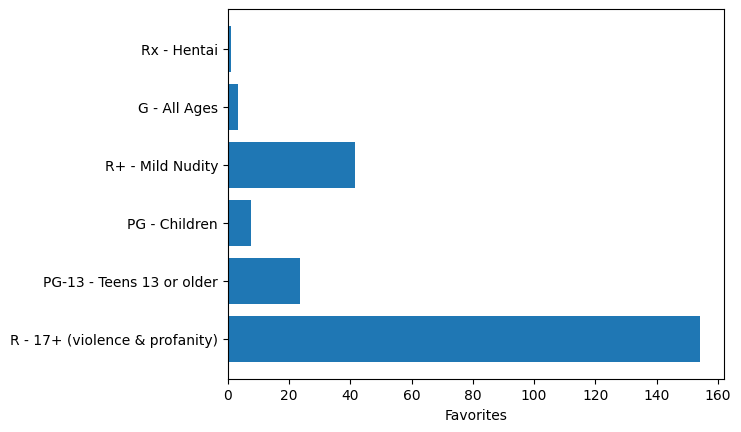

In [646]:
mask = (anime_['Favorites'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN')#&(anime_['Score'] <= 16000)
temp = anime_.loc[mask, ['Favorites', 'Rating', 'Type']]
temp['Favorites'] = temp['Favorites'].astype(float)
temp.loc[temp['Rating'] == 'R - 17+ (violence & profanity)', 'Favorites'] = temp.loc[temp['Rating'] == 'R - 17+ (violence & profanity)', 'Favorites'] / 1411
temp.loc[temp['Rating'] == 'PG-13 - Teens 13 or older', 'Favorites'] = temp.loc[temp['Rating'] == 'PG-13 - Teens 13 or older', 'Favorites'] / 8491
temp.loc[temp['Rating'] == 'PG - Children', 'Favorites'] = temp.loc[temp['Rating'] == 'PG - Children', 'Favorites'] / 4050
temp.loc[temp['Rating'] == 'R+ - Mild Nudity', 'Favorites'] = temp.loc[temp['Rating'] == 'R+ - Mild Nudity', 'Favorites'] / 1134
temp.loc[temp['Rating'] == 'G - All Ages', 'Favorites'] = temp.loc[temp['Rating'] == 'G - All Ages', 'Favorites'] / 7659
temp.loc[temp['Rating'] == 'Rx - Hentai', 'Favorites'] = temp.loc[temp['Rating'] == 'Rx - Hentai', 'Favorites'] / 1475

plt.barh(data=temp, width='Favorites', y = 'Rating')
plt.xlabel('Favorites')

Сделала сразу поправку на количество аниме каждого жанра, аниме жанра Hentai реже всего добавляются в список favorites, чаще всего в список favorites добавляются аниме жанра R - 17+ (violence & profanity) и R+ - Mild Nudity

Text(0.5, 0, 'Members')

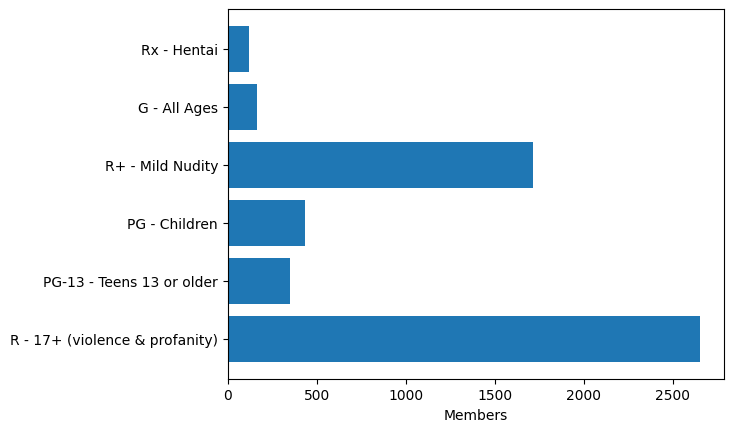

In [648]:
mask = (anime_['Members'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN')#&(anime_['Score'] <= 16000)
temp = anime_.loc[mask, ['Members', 'Rating', 'Type']]
temp['Members'] = temp['Members'].astype(float)
temp.loc[temp['Rating'] == 'R - 17+ (violence & profanity)', 'Members'] = temp.loc[temp['Rating'] == 'R - 17+ (violence & profanity)', 'Members'] / 1411
temp.loc[temp['Rating'] == 'PG-13 - Teens 13 or older', 'Members'] = temp.loc[temp['Rating'] == 'PG-13 - Teens 13 or older', 'Members'] / 8491
temp.loc[temp['Rating'] == 'PG - Children', 'Members'] = temp.loc[temp['Rating'] == 'PG - Children', 'Members'] / 4050
temp.loc[temp['Rating'] == 'R+ - Mild Nudity', 'Members'] = temp.loc[temp['Rating'] == 'R+ - Mild Nudity', 'Members'] / 1134
temp.loc[temp['Rating'] == 'G - All Ages', 'Members'] = temp.loc[temp['Rating'] == 'G - All Ages', 'Members'] / 7659
temp.loc[temp['Rating'] == 'Rx - Hentai', 'Members'] = temp.loc[temp['Rating'] == 'Rx - Hentai', 'Members'] / 1475

plt.barh(data=temp, width='Members', y = 'Rating')
plt.xlabel('Members')

В общем то тенденция такая же как со списком favorites: жанры R - 17+ (violence & profanity) и R+ - Mild Nudity чаще всего добавляются пользователями в их списки. При этом можно заметить, что зрители Hentai чаще добавляют аниме данного жанра к себе в список, чем в список favorites. Кроме того, зрители аниме жанра Children также чаще зрителей жанра teens 13 добавляют аниме в их списки аниме (в добавлении в список favorites наблюдается противоположная тенденция).

#### Рассмотрим как связаны популярность аниме и оценка аниме

<Axes: xlabel='Score', ylabel='Popularity'>

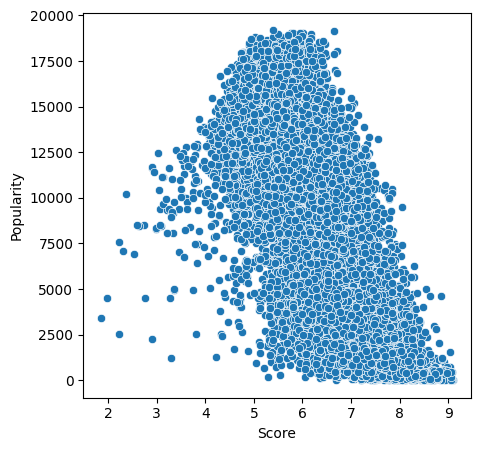

In [607]:
temp = anime_[anime_['Score'] != 'UNKNOWN'].copy()
temp['Score'] = temp['Score'].astype(float)
plt.figure(figsize=(5, 5))
sns.scatterplot(data=temp, x='Score', y='Popularity')

По какой-то причине при уменьшении скора аниме наблюдается увеличение популярности аниме (чем более популярно аниме, тем меньше скоры ему ставят), что и было уже видно на графиках выше.

#### Посмотрим как связаны оценка аниме и количество пользователей, которое добавляло данное аниме в список favorites

<Axes: xlabel='Score', ylabel='Favorites'>

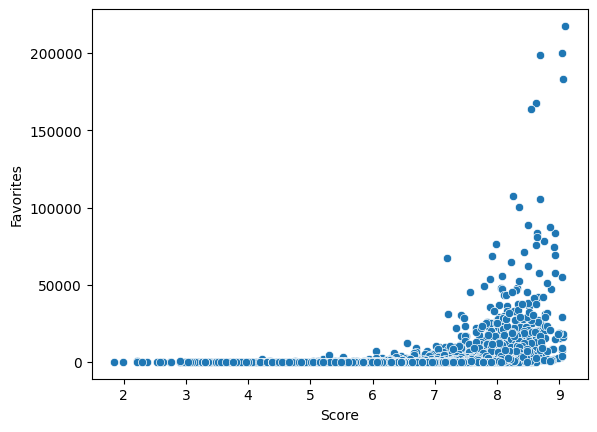

In [21]:
mask = (anime_['Score'] != 'UNKNOWN') & (anime_['Favorites'] != 'UNKNOWN')
temp = anime_.loc[mask, ['Score', 'Favorites']].astype(float)
sns.scatterplot(data=temp, x='Score', y='Favorites')


Видно, что при увеличении оценки аниме пользователи добавляют аниме чаще в список Favorites

In [22]:
res = spearmanr(temp['Score'], temp['Favorites'])
print(f'statistic {res.statistic} pvalue {res.pvalue}')

statistic 0.7547161220695273 pvalue 0.0


Ну такая себе корреляция конечно, но попробуем использовать favorites для предсказания score в градиентном бустинге

#### Проверим зависит ли медианная оценка аниме производства одной студии от студии

<Axes: xlabel='Score', ylabel='Count'>

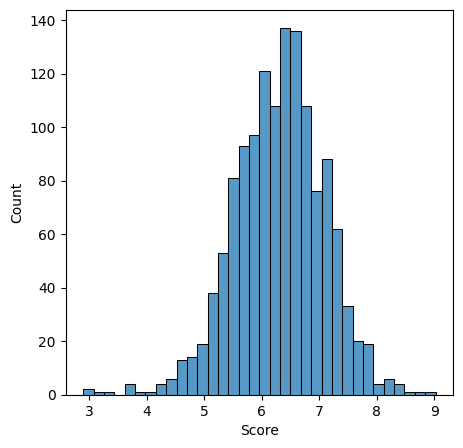

In [704]:
temp = anime_.loc[anime_["Score"] != "UNKNOWN", ["Studios", "Score"]].copy()
temp["Score"] = temp["Score"].astype(float)
medians = temp.groupby("Studios")["Score"].median()
plt.figure(figsize=(5, 5))
sns.histplot(x=medians)

Распределение медианных оценок среди по студиям является нормальным: аниме большинства студий люди ставят в среднем ставят  оценки 6-7, но также есть студии аниме которым люди в среднем ставят более низкие или более высокие оценки.

#### Рассмотрим как связаны оценка и тип аниме

<Axes: xlabel='Score', ylabel='Density'>

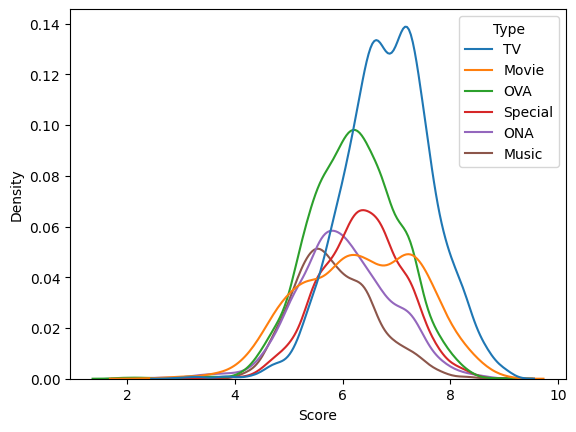

In [715]:
temp = anime_.loc[(anime_["Score"] != "UNKNOWN") & (anime_["Type"] != "UNKNOWN") & (~anime_["Type"].isna()) & (~anime_["Score"].isna()), ["Type", "Score"]].copy()
temp["Score"] = temp["Score"].astype(float)
sns.kdeplot(data=temp, x='Score', hue='Type')
#sns.kdeplot(temp, x='Score', hue='Type')

Вероятно оценка аниме зависит от типа аниме.
Кажется, что оценка аниме выше для ТВ сериалов по сравнению с с оценкой фильмов и оценка ТВ сериалов выше special, проверим это тестом манни-уитни


In [702]:
temp.groupby('Type').describe()

Score                                                  
          count      mean       std   min   25%   50%   75%   max
Type                                                             
Movie    2475.0  6.344137  1.103255  2.37  5.50  6.37  7.23  9.04
Music    1483.0  5.861470  0.755152  3.03  5.33  5.77  6.36  8.85
ONA      1929.0  6.038212  0.884031  2.30  5.47  6.00  6.62  8.72
OVA      3283.0  6.217557  0.833517  1.85  5.64  6.22  6.79  9.02
Special  2039.0  6.365714  0.768633  3.35  5.85  6.37  6.88  9.05
TV       4482.0  6.847144  0.817308  2.90  6.32  6.86  7.39  9.10

In [712]:
temp = anime_.loc[(anime_["Popularity"] != "UNKNOWN") & (anime_["Type"] != "UNKNOWN") & (~anime_["Type"].isna()) & (~anime_["Popularity"].isna()), ["Type", "Popularity"]].copy()
temp["Popularity"] = temp["Popularity"].astype(float)
temp.groupby('Type').describe()

Popularity                                                     \
             count          mean          std  min       25%      50%   
Type                                                                    
Movie       4381.0  13426.331203  6810.297077  0.0   7929.00  14303.0   
Music       2686.0  16674.077811  4731.847812  0.0  14298.00  17752.0   
ONA         3533.0  14191.519955  6306.660286  0.0   9864.00  14441.0   
OVA         4076.0   9933.961237  5226.669121  0.0   6108.75   9004.5   
Special     2558.0  10213.566458  5620.165133  0.0   5590.50   9427.0   
TV          7597.0  11122.027642  8680.170366  0.0   2739.00   9452.0   

                            
              75%      max  
Type                        
Movie    19649.00  24717.0  
Music    19751.75  24713.0  
ONA      19081.00  24723.0  
OVA      13127.50  24678.0  
Special  14477.00  24672.0  
TV       20850.00  24616.0

In [716]:
res = mannwhitneyu(temp.loc[temp['Type'] == 'TV', 'Score'], temp.loc[temp['Type'] == 'Special', 'Score'])
print(f'statistic {res.statistic} p-value {res.pvalue}')

statistic 6103292.0 p-value 5.0068276122760594e-105


In [717]:
res = mannwhitneyu(temp.loc[temp['Type'] == 'TV', 'Score'], temp.loc[temp['Type'] == 'Movie', 'Score'])
print(f'statistic {res.statistic} p-value {res.pvalue}')

statistic 7008436.5 p-value 3.037260605979219e-74


Есть статистически значимое отличие между оценками ТВ сериалов и фильмов - оценка ТВ сериалов в среднем выше оценки фильмов на 0.503 единиц - снова прослеживается тенденция, что более популярные аниме фильмы получают оценку ниже, чем менее популярные ТВ сериалы. 
Есть статистически значимое отличие между оценками ТВ сериалов и special - оценка ТВ сериалов в среднем выше оценки special на 0.4814 единиц - снова прослеживается тенденция, что более популярные аниме фильмы получают оценку ниже, чем менее популярные special. 


#### Рассмотрим как связаны количество серий и популярность аниме, длительность серий и популярность аниме, количество серий и частота добавления в favorites и длительность серий и частота добавления в favorites

<Axes: xlabel='Episodes', ylabel='Popularity'>

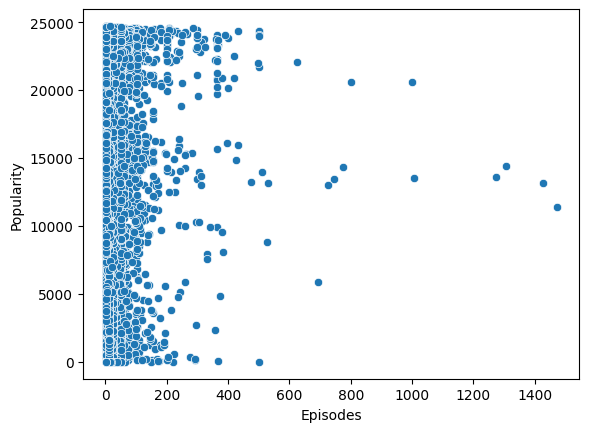

In [816]:
temp = anime_.loc[(anime_['Episodes'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN'), ['Episodes', 'Popularity']].astype(float)
temp = temp.loc[(temp['Episodes'] <= 1500) & (temp['Episodes'] > 0), :]

sns.scatterplot(data=temp, x='Episodes', y='Popularity')

Видимо связи между количеством эпизодов и популярностью нет, совместное распределение количества эпизодов и популярности является равномерно распределенным

In [803]:
anime_.columns

Index(['anime_id', 'Name', 'English name', 'Score', 'Type', 'Episodes',
       'Aired', 'Status', 'Producers', 'Studios', 'Source',
       'Duration per episode', 'Rating', 'Rank', 'Popularity', 'Favorites',
       'Scored By', 'Members', 'is_Comedy', 'is_Suspense', 'is_Ecchi',
       'is_Sci-Fi', 'is_Sports', 'is_Adventure', 'is_Slice of Life',
       'is_Romance', 'is_Fantasy', 'is_Drama', 'is_Supernatural', 'is_Mystery',
       'is_Erotica', 'is_Award Winning', 'is_Hentai', 'is_Girls Love',
       'is_Horror', 'is_Boys Love', 'is_Action', 'is_Gourmet',
       'is_Avant Garde'],
      dtype='object')

<Axes: xlabel='Duration per episode', ylabel='Popularity'>

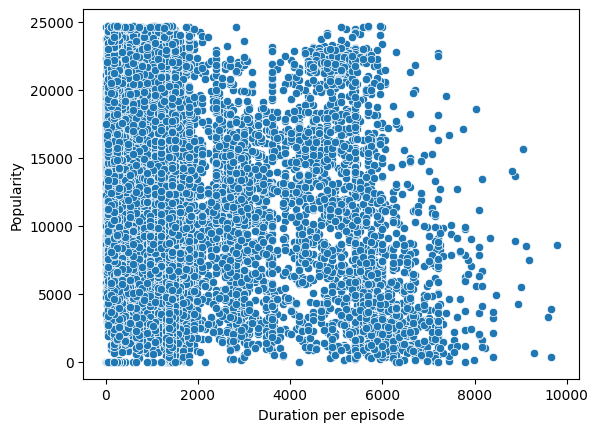

In [817]:
temp = anime_.loc[(anime_['Duration per episode'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN'), ['Duration per episode', 'Popularity']].astype(float)
temp = temp.loc[(temp['Duration per episode'] <= 10000) & (temp['Duration per episode'] > 0), :]
sns.scatterplot(data=temp, x='Duration per episode', y='Popularity')

Между длительностью одной серии аниме и популярностью зависимости также нет, совместное распределение является равномерным

<Axes: xlabel='Episodes', ylabel='Favorites'>

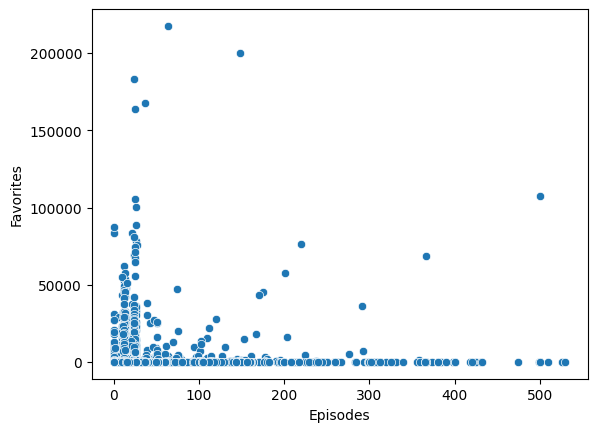

In [824]:
temp = anime_.loc[(anime_['Episodes'] != 'UNKNOWN') & (anime_['Favorites'] != 'UNKNOWN'), ['Episodes', 'Favorites']].astype(float)
temp = temp.loc[(temp['Episodes'] <= 600) & (temp['Episodes'] > 0), :]
sns.scatterplot(data=temp, x='Episodes', y='Favorites')

Duration per episode     1440.0
Favorites               31121.0
dtype: float64


<Axes: xlabel='Duration per episode', ylabel='Favorites'>

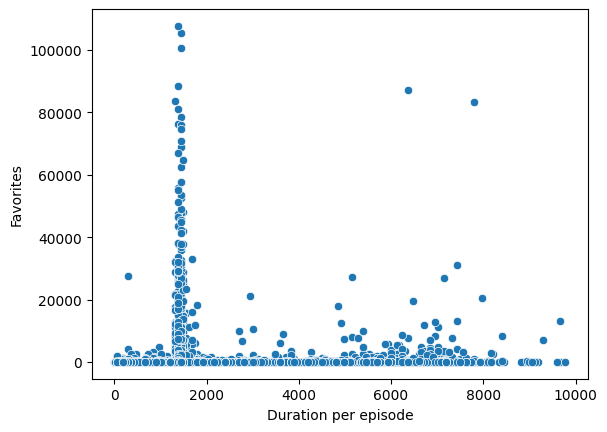

In [830]:
temp = anime_.loc[(anime_['Duration per episode'] != 'UNKNOWN') & (anime_['Favorites'] != 'UNKNOWN'), ['Duration per episode', 'Favorites']].astype(float)
temp = temp.loc[(temp['Duration per episode'] <= 10000) & (temp['Duration per episode'] > 0), :]
temp = temp.loc[temp['Favorites'] < 150000, :]
eval = temp.loc[(temp['Favorites'] > 20000) & (temp['Duration per episode'] > 1000), :]
print(eval.median())
sns.scatterplot(data=temp, x='Duration per episode', y='Favorites')

Видимо наиболее часто добавляемыми в список favorites аниме являются аниме с количеством эпизодов 1440, что в общем то не является неожиданным, популярная длина аниме это 24 минуты

In [832]:
anime_.loc[(anime_['Favorites'] > 20000) & (anime_['Duration per episode'] > 1000), ['English name', 'Name', 'Duration per episode', 'Favorites']].sort_values(by='Favorites')

,English name,Name,Duration per episode,Favorites
6589,Fate/Zero Season 2,Fate/Zero 2nd Season,1440,20090
239,Fighting Spirit,Hajime no Ippo,1380,20143
11594,Yuri!!! On ICE,Yuri!!! on Ice,1380,20180
142,Princess Mononoke,Mononoke Hime,7980,20632
6602,Kuroko's Basketball,Kuroko no Basket,1440,20710
...,...,...,...,...
1393,Death Note,Death Note,1380,167586
5667,Steins;Gate,Steins;Gate,1440,182964
11,One Piece,One Piece,1440,198986
6456,Hunter x Hunter,Hunter x Hunter (2011),1380,200265


#### Выведем топ 25 аниме по популярности

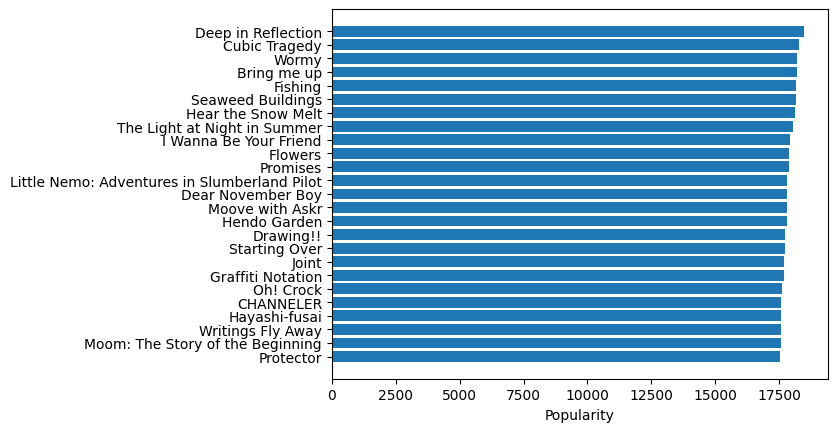

In [664]:
#Топ 25 аниме по популярности
temp = anime_.loc[(anime_['English name'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN') & (anime_['Rank'] != 'UNKNOWN') & (anime_['Score'] != 'UNKNOWN') & (anime_['English name'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN'), ['Name', 'English name', 'Rating', 'Popularity', 'Rank', 'Score']]
temp['Popularity'] = temp['Popularity'].astype(float)
plt.barh(data = temp.sort_values(by='Popularity', ascending=False).iloc[:25, :], y = 'English name', width = 'Popularity')
plt.xlabel('Popularity')
plt.gca().invert_yaxis()

Самым популярным аниме является аниме Deep in Reflection

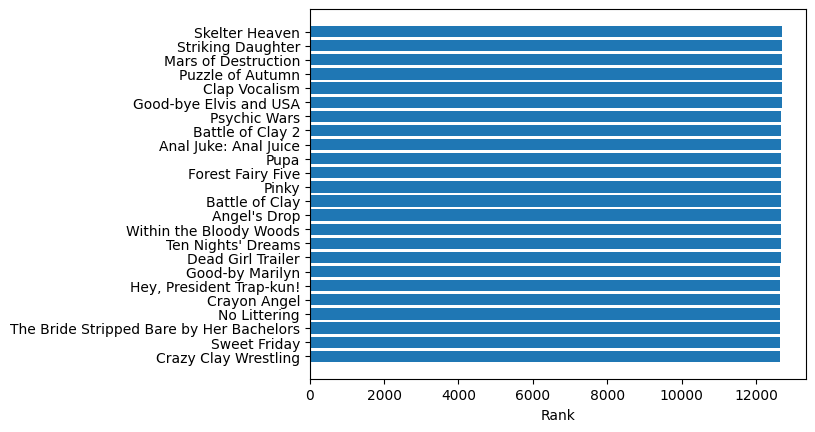

In [669]:
temp = anime_.loc[(anime_['English name'] != 'UNKNOWN') & (anime_['Members'] != 'UNKNOWN') & (anime_['Rank'] != 'UNKNOWN') & (anime_['Score'] != 'UNKNOWN') & (anime_['English name'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN'), ['Name', 'English name', 'Rating', 'Members', 'Rank', 'Score']]
temp['Rank'] = temp['Rank'].astype(float)
plt.barh(data = temp.sort_values(by='Rank', ascending=False).iloc[:25, :], y = 'English name', width = 'Rank')
plt.xlabel('Rank')
plt.gca().invert_yaxis()

In [671]:
temp.sort_values(by='Rank', ascending=False).iloc[:25, :]

,Name,English name,Rating,Members,Rank,Score
2925,Tenkuu Danzai Skelter+Heaven,Skelter Heaven,PG-13 - Teens 13 or older,37328,12701.0,1.85
6947,Utsu Musume Sayuri,Striking Daughter,R+ - Mild Nudity,20789,12699.0,1.98
387,Hametsu no Mars,Mars of Destruction,R - 17+ (violence & profanity),65622,12698.0,2.22
8594,Aki no Puzzle,Puzzle of Autumn,R+ - Mild Nudity,2313,12696.0,2.37
4823,Ningen Doubutsuen,Clap Vocalism,PG-13 - Teens 13 or older,4199,12693.0,2.74
10043,Good-by Elvis and USA,Good-bye Elvis and USA,R+ - Mild Nudity,1529,12687.0,2.95
1215,Soujuu Senshi Psychic Wars,Psychic Wars,R+ - Mild Nudity,4314,12681.0,3.08
6632,Nendo no Tatakai 2,Battle of Clay 2,PG-13 - Teens 13 or older,2531,12678.0,3.19
10636,Koumon-teki Juuku Ketsujiru Juke,Anal Juke: Anal Juice,R+ - Mild Nudity,1420,12674.0,3.26
8036,Pupa,Pupa,R - 17+ (violence & profanity),183140,12671.0,3.29


Ранг аниме ожидаемо просто порядковый номер аниме в рейтинге

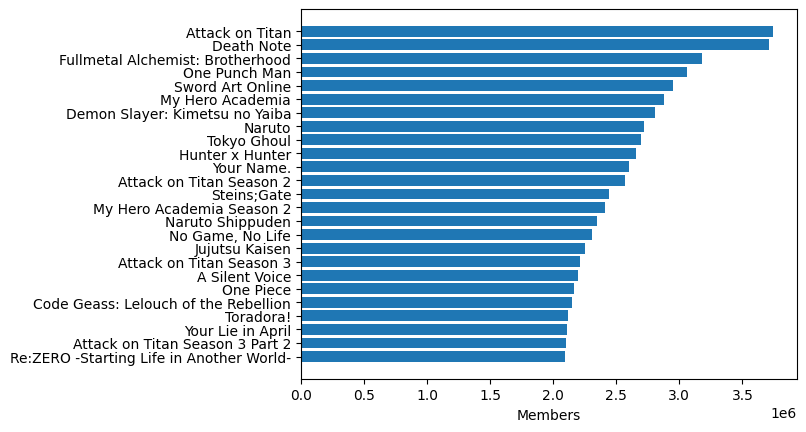

In [666]:
temp = anime_.loc[(anime_['English name'] != 'UNKNOWN') & (anime_['Members'] != 'UNKNOWN') & (anime_['Rank'] != 'UNKNOWN') & (anime_['Score'] != 'UNKNOWN') & (anime_['English name'] != 'UNKNOWN') & (anime_['Rating'] != 'UNKNOWN'), ['Name', 'English name', 'Rating', 'Members', 'Rank', 'Score']]
temp['Members'] = temp['Members'].astype(float)
plt.barh(data = temp.sort_values(by='Members', ascending=False).iloc[:25, :], y = 'English name', width = 'Members')
plt.xlabel('Members')
plt.gca().invert_yaxis()

Распределение аниме по количеству участников, которые добавляют данное аниме к себе в список, кажется более разумным, чаще всего к себе в список добавляют Атаку Титанов и Death Note

#### В датасете написано, что ранг аниме зависит от популярности, но не описано как точно, исследуем это

<Axes: xlabel='Popularity', ylabel='Rank'>

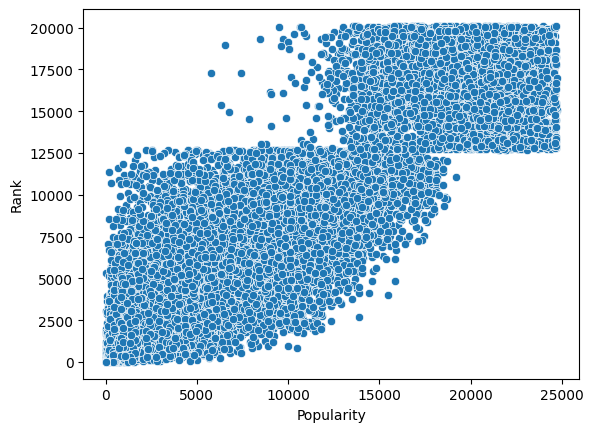

In [ ]:
temp = anime_.loc[(anime_['Rank'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN') , ['Rank', 'Popularity']].astype(float)
sns.scatterplot(data=temp, x='Popularity', y='Rank')

Как мы уже выяснили, ранг отражает порядковый номер аниме в рейтинге, видимо он все же зависит от популярности, но не совсем линейно и видимо учитывает другие признаки, тк аниме одинаковой популярности обладают разными рангами.

#### Обучим градиентный бустинг на one-hot закодированных жанрах, popularity, type, favorites для предсказания оценки аниме

In [443]:
anime_.columns

Index(['anime_id', 'Name', 'English name', 'Score', 'Type', 'Episodes',
       'Aired', 'Status', 'Producers', 'Studios', 'Source',
       'Duration per episode', 'Rating', 'Rank', 'Popularity', 'Favorites',
       'Scored By', 'Members', 'is_Comedy', 'is_Suspense', 'is_Ecchi',
       'is_Sci-Fi', 'is_Sports', 'is_Adventure', 'is_Slice of Life',
       'is_Romance', 'is_Fantasy', 'is_Drama', 'is_Supernatural', 'is_Mystery',
       'is_Erotica', 'is_Award Winning', 'is_Hentai', 'is_Girls Love',
       'is_Horror', 'is_Boys Love', 'is_Action', 'is_Gourmet',
       'is_Avant Garde'],
      dtype='object')

In [505]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [763]:
FEATURES = ['is_Comedy', 'is_Suspense', 'is_Ecchi',
       'is_Sci-Fi', 'is_Sports', 'is_Adventure', 'is_Slice of Life',
       'is_Romance', 'is_Fantasy', 'is_Drama', 'is_Supernatural', 'is_Mystery',
       'is_Erotica', 'is_Award Winning', 'is_Hentai', 'is_Girls Love',
       'is_Horror', 'is_Boys Love', 'is_Action', 'is_Gourmet',
       'is_Avant Garde', 'Popularity', 'Type', 'Favorites', 'Score']
mask = (anime_['Score'] != 'UNKNOWN') & (anime_['Popularity'] != 'UNKNOWN') & (anime_['Type'] != 'UNKNOWN') & (anime_['Favorites'] != 'UNKNOWN')
data = anime_.loc[mask, FEATURES]


In [764]:
data['Type'].unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music'], dtype=object)

In [765]:
one_hot = OneHotEncoder()
features = one_hot.fit_transform(data[['Type']]).toarray()

type_one_hot_df = pd.DataFrame(
    data={
        name: features[:, i]
        for i, name in enumerate(one_hot.get_feature_names_out())
    }
)

data = pd.concat([data, type_one_hot_df], axis=1)
data = data[~(data.isna().any(axis=1))]
data

,is_Comedy,is_Suspense,is_Ecchi,is_Sci-Fi,is_Sports,is_Adventure,is_Slice of Life,is_Romance,is_Fantasy,is_Drama,...,Popularity,Type,Favorites,Score,Type_Movie,Type_Music,Type_ONA,Type_OVA,Type_Special,Type_TV
0,False,False,False,True,False,False,False,False,False,False,...,43.0,TV,78525.0,8.75,0.0,0.0,0.0,0.0,0.0,1.0
1,False,False,False,True,False,False,False,False,False,False,...,602.0,Movie,1448.0,8.38,1.0,0.0,0.0,0.0,0.0,0.0
2,False,False,False,True,False,True,False,False,False,False,...,246.0,TV,15035.0,8.22,0.0,0.0,0.0,0.0,0.0,1.0
3,False,False,False,False,False,False,False,False,False,True,...,1795.0,TV,613.0,7.25,0.0,0.0,0.0,0.0,0.0,1.0
4,False,False,False,False,False,True,False,False,True,False,...,5126.0,TV,14.0,6.94,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15684,False,False,False,False,False,False,False,False,False,True,...,3475.0,Movie,305.0,7.41,0.0,0.0,0.0,1.0,0.0,0.0
15687,True,False,False,False,False,False,False,False,False,True,...,4695.0,Movie,93.0,7.74,0.0,1.0,0.0,0.0,0.0,0.0
15688,False,False,False,False,False,False,False,False,False,False,...,16280.0,Music,0.0,6.17,0.0,0.0,0.0,0.0,1.0,0.0
15689,False,False,False,False,False,False,False,True,True,False,...,13133.0,ONA,10.0,6.62,0.0,0.0,0.0,0.0,1.0,0.0


In [766]:
X = data.iloc[:, :].drop(['Type', 'Score'], axis=1)
Y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [770]:
y_test

6647      6.5
6525     5.73
304      5.98
15019    6.72
2419     6.99
         ... 
4940     6.33
2374     5.69
8817     6.01
4148     6.34
3352     6.09
Name: Score, Length: 2593, dtype: object

In [782]:
gb = GradientBoostingRegressor(learning_rate=0.3)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
importances_df = pd.DataFrame({'Feature': gb.feature_names_in_, 'importance': gb.feature_importances_ }).sort_values(by='importance', ascending = False)
print(importances_df)
print()
print(f'r2 score {r2_score(y_test, y_pred)}')

             Feature  importance
21        Popularity    0.539779
22         Favorites    0.331546
20    is_Avant Garde    0.027941
14         is_Hentai    0.021892
16         is_Horror    0.014344
5       is_Adventure    0.011977
2           is_Ecchi    0.010895
9           is_Drama    0.007689
0          is_Comedy    0.004281
4          is_Sports    0.003952
11        is_Mystery    0.003906
17      is_Boys Love    0.003833
8         is_Fantasy    0.003357
6   is_Slice of Life    0.001757
12        is_Erotica    0.001526
19        is_Gourmet    0.001448
18         is_Action    0.001392
1        is_Suspense    0.001291
13  is_Award Winning    0.001021
3          is_Sci-Fi    0.001005
7         is_Romance    0.000882
10   is_Supernatural    0.000864
25          Type_ONA    0.000850
24        Type_Music    0.000723
27      Type_Special    0.000577
15     is_Girls Love    0.000461
23        Type_Movie    0.000364
26          Type_OVA    0.000307
28           Type_TV    0.000141

r2 score 

Ура на данных фичах модель неплохо предсказывает оценку аниме! Самой важной фичей для предсказания модели являются популярность и частота добавления аниме в список избранных аниме

#### Попробуем предсказать как часто аниме будет добавлено в список favorites по всем признакам без score (убрала оценку, потому что она буквально является признаком-спойлером для модели)

In [788]:
X = data.iloc[:, :].drop(['Type', 'Score', 'Favorites'], axis=1)
Y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [789]:
gb = GradientBoostingRegressor(learning_rate=0.8)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
importances_df = pd.DataFrame({'Feature': gb.feature_names_in_, 'importance': gb.feature_importances_ }).sort_values(by='importance', ascending = False)
print(importances_df)
print(r2_score(y_test, y_pred))

             Feature  importance
21        Popularity    0.844514
20    is_Avant Garde    0.029719
14         is_Hentai    0.020858
2           is_Ecchi    0.015219
9           is_Drama    0.014862
5       is_Adventure    0.014795
16         is_Horror    0.012781
8         is_Fantasy    0.005081
0          is_Comedy    0.004349
4          is_Sports    0.004079
7         is_Romance    0.003581
11        is_Mystery    0.003521
17      is_Boys Love    0.002823
18         is_Action    0.002695
6   is_Slice of Life    0.002638
25          Type_OVA    0.002602
3          is_Sci-Fi    0.002203
19        is_Gourmet    0.002038
23        Type_Music    0.002029
13  is_Award Winning    0.001901
24          Type_ONA    0.001588
12        is_Erotica    0.001571
26      Type_Special    0.001499
10   is_Supernatural    0.000875
22        Type_Movie    0.000854
1        is_Suspense    0.000738
15     is_Girls Love    0.000362
27           Type_TV    0.000227
0.6142194737544564


Для предсказания частоты добавления аниме в список избранное ожидаемо наиболее важной фичей является популярность, r2 score здесь тоже лучше монетки, но все равно оставляет желать лучшего

# Выводы
1. Среди пользователей данной платформы наблюдаются аномально активные пользователи, активно добавляющие в свои списки аниме и активно смотрящие аниме, возможно это аниме-энтузиасты
2. Средняя оценка, выставляемая женщинами аниме, в среднем выше, чем для мужчин
3. Наиболее популярными типами аниме являются фильмы, ONA, music, а по возрастным категориям самой популярной категорией являются фильмы для детей.
4. Аниме жанра Hentai реже всего добавляются в список favorites, чаще всего в список favorites добавляются аниме жанра R - 17+ (violence & profanity) и R+ - Mild Nudity.
5. Аниме с высокой популярностью обладают более низкой оценкой, чем менее популярные аниме.
6. При увеличении оценки аниме пользователи добавляют аниме чаще в список Favorites
7. Медианная оценка аниме производства одной студии зависит от выпустившей их студии, распределение медианных оценок является нормальным. 
8. Оценка аниме зависит от формата выпуска аниме: оценка ТВ сериалов выше оценки фильмов и special
9. Связь между количеством эпизодов и популярностью не была выявлена.

